# Projeto 4

### Alura - Curso: Machine Learning: classificação com SKLearn</br>Professor Guilherme Silveira</br>11/07/2022 

### Base de dados de carros vendidos em um site online, colunas:
* mileage_per_year - milhar percorridas por anos;</br>
* model_year - ano do modelo do carro;
* price - preço do carro anuncioado;
* sold - se o carro foi vendido ou não (atributo alvo).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

In [2]:
uri = 'https://gist.githubusercontent.com/guilhermesilveira/4d1d4a16ccbf6ea4e0a64a38a24ec884/raw/afd05cb0c796d18f3f5a6537053ded308ba94bf7/car-prices.csv'
df_carros = pd.read_csv(uri)

In [3]:
print(f'Quantidade de anúncios de carro - {df_carros.shape[0]}')
df_carros.head()

Quantidade de anúncios de carro - 10000


,Unnamed: 0,mileage_per_year,model_year,price,sold
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes


### Visualizando distribuição de carros vendidos vs não vendidos

yes    5800
no     4200
Name: sold, dtype: int64


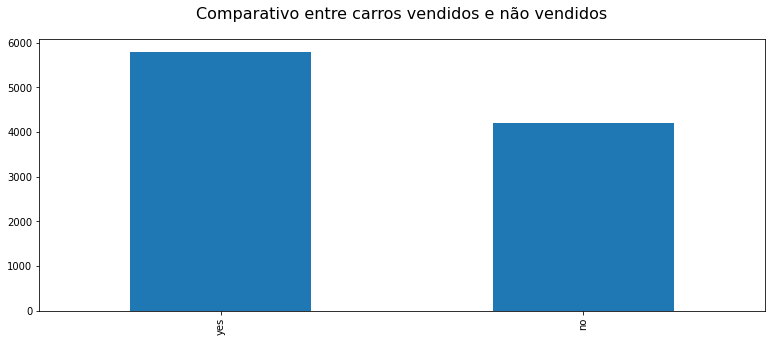

In [4]:
print(df_carros.sold.value_counts())

plt.figure(figsize=(13, 5))
plt.title("Comparativo entre carros vendidos e não vendidos", fontsize=16, pad=20)
df_carros.sold.value_counts().plot(kind='bar')
plt.show()

### Limpeza inicial da base de dados

Renomeando colunas

In [5]:
mapa = {
    'mileage_per_year' : 'milhas_por_ano',
    'model_year' : 'ano_do_modelo',
    'price' : 'preco',
    'sold' : 'vendido'
}

df_carros.rename(columns=mapa, inplace=True)

df_carros.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes


Alterando o atributo vendido de no/yes para 0/1

In [6]:
mapa = {
    'no': 0,
    'yes' : 1
}

df_carros.vendido = df_carros.vendido.map(mapa)

df_carros.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido
0,0,21801,2000,30941.02,1
1,1,7843,1998,40557.96,1
2,2,7109,2006,89627.50,0
3,3,26823,2015,95276.14,0
4,4,7935,2014,117384.68,1


Calculando a idade do carro e atribuindo a coluna idade_do_modelo

In [7]:
# datetime.today().year recupera a data atual e na seuqencia somente o ano
df_carros['idade_do_modelo'] = datetime.today().year - df_carros.ano_do_modelo

df_carros.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido,idade_do_modelo
0,0,21801,2000,30941.02,1,22
1,1,7843,1998,40557.96,1,24
2,2,7109,2006,89627.50,0,16
3,3,26823,2015,95276.14,0,7
4,4,7935,2014,117384.68,1,8


Criando a coluna km_por_ano a partir do atributo milhas_por_ano</br>
[Cálculadora de milhas para quilometros](https://www.google.com/search?q=calculadora+milhas+quilometros&oq=calculadora+km+milhas&aqs=edge.1.69i57j0i22i30l2.10023j0j1&sourceid=chrome&ie=UTF-8)

In [8]:
df_carros['km_por_ano'] = df_carros.milhas_por_ano * 1.60934

df_carros.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido,idade_do_modelo,km_por_ano
0,0,21801,2000,30941.02,1,22,35085.22134
1,1,7843,1998,40557.96,1,24,12622.05362
2,2,7109,2006,89627.50,0,16,11440.79806
3,3,26823,2015,95276.14,0,7,43167.32682
4,4,7935,2014,117384.68,1,8,12770.11290


Excluindo campo que não será utilizado

In [9]:
del df_carros['Unnamed: 0']
del df_carros['milhas_por_ano']
del df_carros['ano_do_modelo']

df_carros.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,22,35085.22134
1,40557.96,1,24,12622.05362
2,89627.50,0,16,11440.79806
3,95276.14,0,7,43167.32682
4,117384.68,1,8,12770.11290


### Separando a base entre dados de treino e teste

In [10]:
X = df_carros[['preco', 'idade_do_modelo', 'km_por_ano']]
y = df_carros['vendido']

In [11]:
SEED = 5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

print(f'Treino com {X_train.shape[0]} anúncios de carro, e teste com {X_test.shape[0]} anúncios de carro.')

Treino com 7500 anúncios de carro, e teste com 2500 anúncios de carro.


### Parte I - Avaliando com DummyClassifier
Se não houvesse modelo nenhum, qual seria meu grau de acertos? Será minha linha de base para comparar com os modelos que serão criados.

#### Estratégias utilizadas pelo DummyClassifier:
* most_frequent  - sempre retorna o rótulo de classe mais frequente
* prior *Default - sempre retorna o rótulo de classe mais frequente
* stratified     - proporcional aos dados de entrada
* uniform        - gera previsões uniformemente aleatoriamente
* constant       - sempre prevê um rótulo constante fornecido pelo usuário


In [12]:
dummy = DummyClassifier(strategy='most_frequent', random_state=SEED)
dummy.fit(X_train, y_train)

previsoes = dummy.predict(X_test)

taxa_acertos =  accuracy_score(y_test, previsoes) * 100
print(f'Percentual de acurácia do DummyClassifier most_frequent - {(taxa_acertos):.2f}%')
print(f'Percentual de acurácia do DummyClassifier most_frequent - {(dummy.score(X_test, y_test) * 100):.2f}%')

Percentual de acurácia do DummyClassifier most_frequent - 59.16%
Percentual de acurácia do DummyClassifier most_frequent - 59.16%


In [13]:
dummy = DummyClassifier(strategy='prior', random_state=SEED)
dummy.fit(X_train, y_train)

previsoes = dummy.predict(X_test)

taxa_acertos =  accuracy_score(y_test, previsoes) * 100
print(f'Percentual de acurácia do DummyClassifier prior - {(taxa_acertos):.2f}%')
print(f'Percentual de acurácia do DummyClassifier prior - {(dummy.score(X_test, y_test) * 100):.2f}%')

Percentual de acurácia do DummyClassifier prior - 59.16%
Percentual de acurácia do DummyClassifier prior - 59.16%


In [14]:
dummy = DummyClassifier(strategy='stratified', random_state=SEED)
dummy.fit(X_train, y_train)

previsoes = dummy.predict(X_test)

taxa_acertos =  accuracy_score(y_test, previsoes) * 100
print(f'Percentual de acurácia do DummyClassifier stratified - {(taxa_acertos):.2f}%')
print(f'Percentual de acurácia do DummyClassifier stratified - {(dummy.score(X_test, y_test) * 100):.2f}%')

Percentual de acurácia do DummyClassifier stratified - 52.00%
Percentual de acurácia do DummyClassifier stratified - 52.00%


### Parte II - Gerando o modelo para previsão LinearSVC()
1- Intânciar - LinearSVC();</br>
2- Treinar - fit();</br>
3- Prever - predict();</br>
4- Varificação da acurácia.

In [15]:
cls_linear_svc = LinearSVC(random_state=SEED)
cls_linear_svc.fit(X_train, y_train)

previsoes = cls_linear_svc.predict(X_test)

taxa_acertos =  accuracy_score(y_test, previsoes) * 100

print(f'Percentual de acurácia - {(taxa_acertos):.2f}%')

Percentual de acurácia - 59.16%


C:\Users\renat\Envs\alura_ml_070722\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<font color='red'>
    Modelo LinearSVC() muito ruim, atingindo a mesma acurácia do DummyClassifier
</font>

### Parte III - Gerando o modelo para previsão SVC()
1- Reescalando valores;</br>
2- Intânciar - LinearSVC();</br>
3- Treinar - fit();</br>
4- Prever - predict();</br>
5- Varificação da acurácia.

In [16]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)

In [17]:
cls_svc = SVC(random_state=SEED)
cls_svc.fit(X_train_scaler, y_train)

previsoes = cls_svc.predict(X_test_scaler)

taxa_acertos =  accuracy_score(y_test, previsoes) * 100

print(f'Percentual de acurácia - {(taxa_acertos):.2f}%')
print(f'Percentual de acurácia - {(cls_svc.score(X_test_scaler, y_test) * 100):.2f}%')

Percentual de acurácia - 76.80%
Percentual de acurácia - 76.80%


<font color='blue'>
    Modelo SVC() alcançou 76,80% de acerto, com uma melhora sobre o modelo aleatório.
</font>

### Parte IV - Modelo de árvore de dicisão DecisionTreeClassifier()
Modelo interessante:
* permite entender qual foi motivo que levou a chegar no valor previsto;
* não exige reescalar as features.

In [18]:
cls_tree = DecisionTreeClassifier(random_state=SEED)
cls_tree.fit(X_train, y_train)

previsoes = cls_tree.predict(X_test)

taxa_acertos =  accuracy_score(y_test, previsoes) * 100

print(f'Percentual de acurácia - {(taxa_acertos):.2f}%')
print(f'Percentual de acurácia - {(cls_tree.score(X_test, y_test) * 100):.2f}%')

Percentual de acurácia - 73.40%
Percentual de acurácia - 73.40%


Limitando o tamanho da árvore com o atributo max_depth

In [19]:
cls_tree = DecisionTreeClassifier(random_state=SEED, max_depth=3)
cls_tree.fit(X_train, y_train)

previsoes = cls_tree.predict(X_test)

taxa_acertos =  accuracy_score(y_test, previsoes) * 100

print(f'Percentual de acurácia - {(taxa_acertos):.2f}%')
print(f'Percentual de acurácia - {(cls_tree.score(X_test, y_test) * 100):.2f}%')

Percentual de acurácia - 78.76%
Percentual de acurácia - 78.76%


Para plotar a árvore de decisão é preciso instalaçã do [graphviz](https://graphviz.org/download/) no sistema operacional.

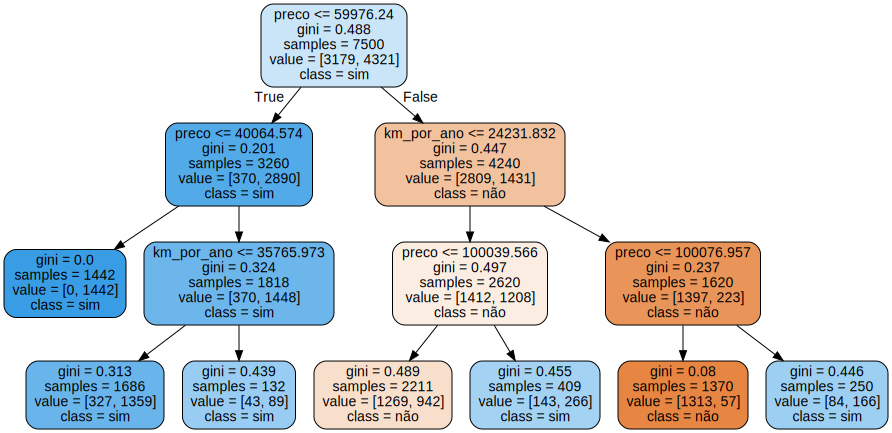

In [20]:
dot_data = export_graphviz(
    cls_tree,                                  # Modelo 
    feature_names=X_train.columns,             # Nomes dos atributos independentes
    class_names=['não', 'sim'],                # Nomes dos atributos dependentes
    filled=True,                               # Preencher verdadeiro
    rotate=False,                              # Plotar True-horizontal ou False-Vertical
    rounded=True                               # Arredondado
)

graphviz.Source(dot_data)